# OKeefe-Burgess experiments

This notebook reproduces the place field remapping experiments in a square/rectangular arena,  
with results corresponding to Figure 3A of our [paper](https://www.science.org/doi/epdf/10.1126/sciadv.adm8470).


## Imports

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})




from cscg import cscg_factory
from cscg import utils

## Create environments and generate training data

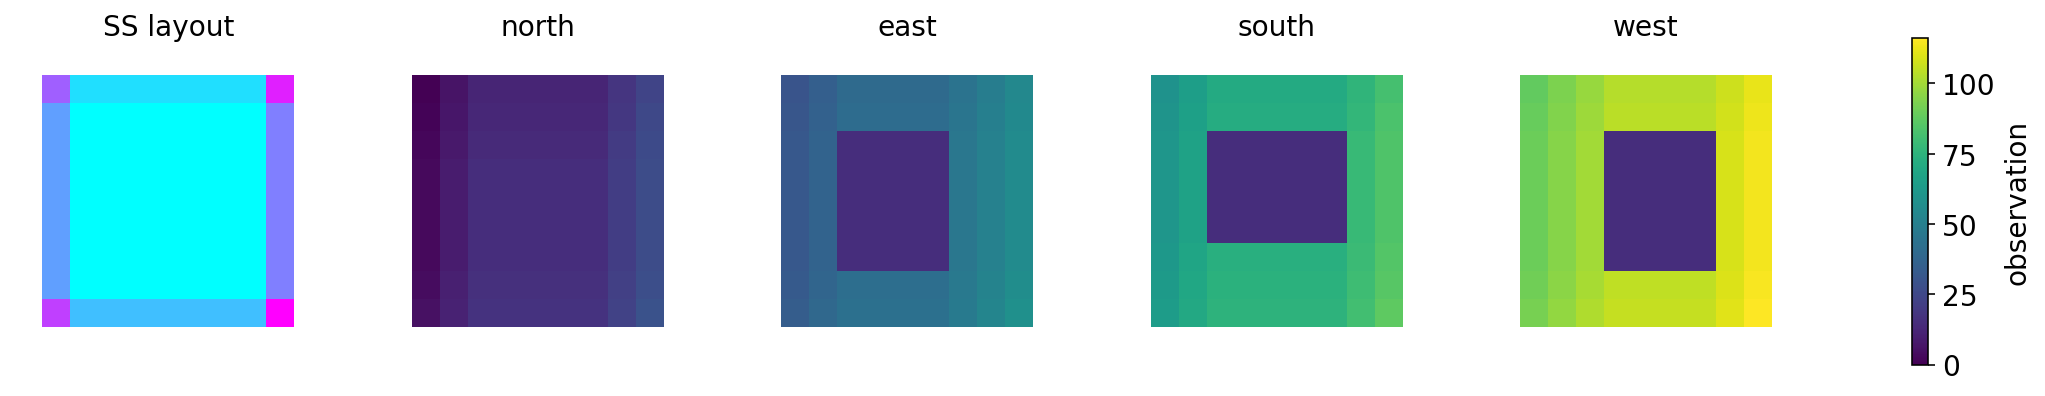

In [2]:
#@title Create Small Square (SS) layout
PH, PW = 4, 3  # patch height and width to use for egocentric observations
rH, rW = 9, 9  # room height and width
room_layout = utils.generate_rectangular_layout(
    rH, rW, padlen=PH, distinct_edges=True, distinct_corners=True
)

# generate egocentric observations in SS layout

observation_dict = {}
observation_map, observation_dict = utils.extract_egocentric_observations(
    room_layout, PH, PW, observation_dict
)

po = PH - 1  # plot offset
labels = ['SS layout', 'north', 'east', 'south', 'west']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(utils.nan_outside(room_layout[po:-po, po:-po]), cmap='cool')
for i in range(5):
  if i > 0:
    pcm = axs[i].imshow(
        utils.nan_outside(observation_map[i - 1][po:-po, po:-po]),
        vmin=0,
        vmax=observation_map.max(),
    )
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(labels[i], fontsize=14)
  axs[i].axis('off')

fig.colorbar(pcm, ax=axs, shrink=0.75, label='observation')

plt.show()

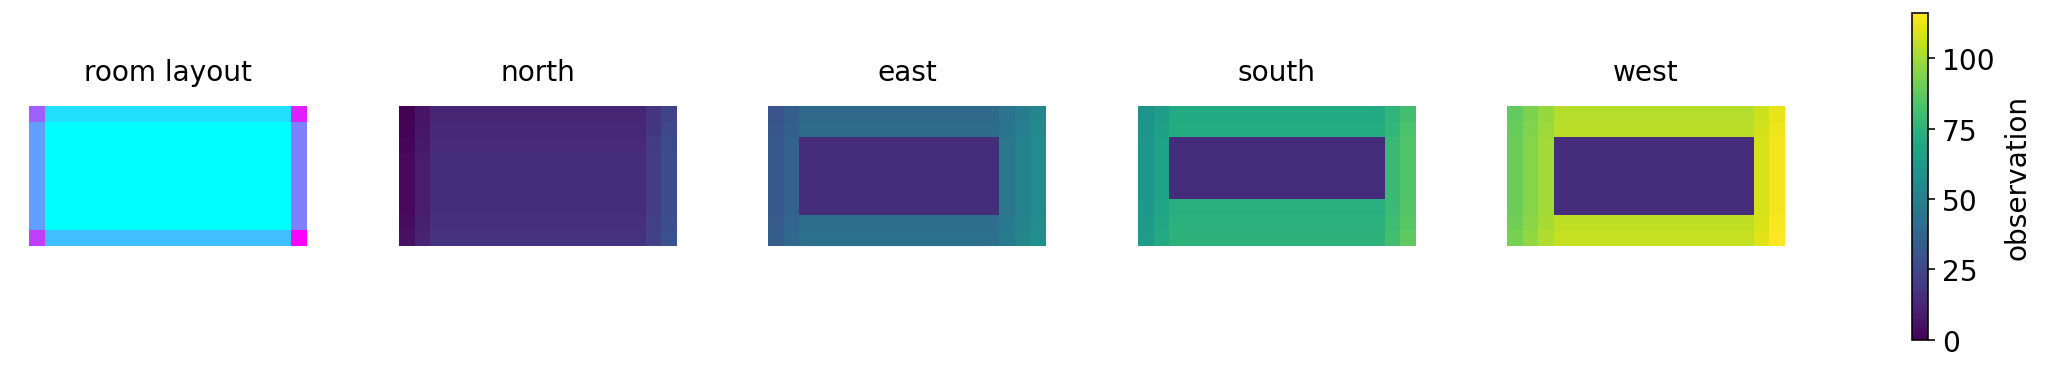

In [3]:
# @title Create Horizontal Rectangle (HR) layout
room_layout_HR = utils.generate_rectangular_layout(
    rH, 2 * rW, padlen=PH, distinct_edges=True, distinct_corners=True
)  # using patch height as the padding

# generate egocentric observations in HR layout

observation_map_HR, _ = utils.extract_egocentric_observations(
    room_layout_HR, PH, PW, observation_dict.copy()
)

labels = ['room layout', 'north', 'east', 'south', 'west']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(utils.nan_outside(room_layout_HR[po:-po, po:-po]), cmap='cool')
for i in range(5):
  if i > 0:
    pcm = axs[i].imshow(
        utils.nan_outside(observation_map_HR[i - 1][po:-po, po:-po]),
        vmin=0,
        vmax=observation_map.max(),
    )
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(labels[i], fontsize=14)
  axs[i].axis('off')

fig.colorbar(pcm, ax=axs, shrink=0.75, label='observation')

plt.show()

In [4]:
# @title Generate training data for the CSCG in the SS layout

length = 250_000
H, W = observation_map.shape[1:]
sr, sc, sh = H // 2, W // 2, 0

a, x, rc, h = utils.generate_egocentric_random_walk(
    observation_map.copy(), sr, sc, sh, length, seed=42
)

print(x.shape, a.shape)

(250000,) (250000,)


## Train CSCG

In [5]:
# @title set n_clones
n_emissions = observation_map.max() + 1
n_clones = 2 * (np.unique(observation_map, return_counts=True)[1][1:])

In [6]:
# @title Initialize CSCG
pseudocount = 5e-4
kwargs = dict(
    n_clones=n_clones,
    pseudocount=pseudocount,
    n_actions=len(np.unique(a)),
    batched=True,
    use_bfloat16=False,
)

model = cscg_factory.build_cscg(implementation='he', seed=42, kwargs=kwargs)

In [7]:
# @title EM learning
convergence_em = model.learn_em_transition(observations=x, actions=a, n_iter=2000)

 48%|████▊     | 958/2000 [11:20<12:20,  1.41it/s, train_bps=0.04767422]


In [8]:
# @title Viterbi learning
convergence_vit = model.learn_viterbi_transition(
    observations=x, actions=a, n_iter=100
)

 10%|█         | 10/100 [00:06<01:01,  1.46it/s, train_bps=0.059975415]


In [9]:
# @title Decode states
states = model.decode(observations=x, actions=a)[1]
print(
    'No. of locations in the room x No. of headings =',
    (room_layout > -1).sum() * 4,
)
print(f'No. of unique states: {len(np.unique(states))}')

No. of locations in the room x No. of headings = 324
No. of unique states: 332


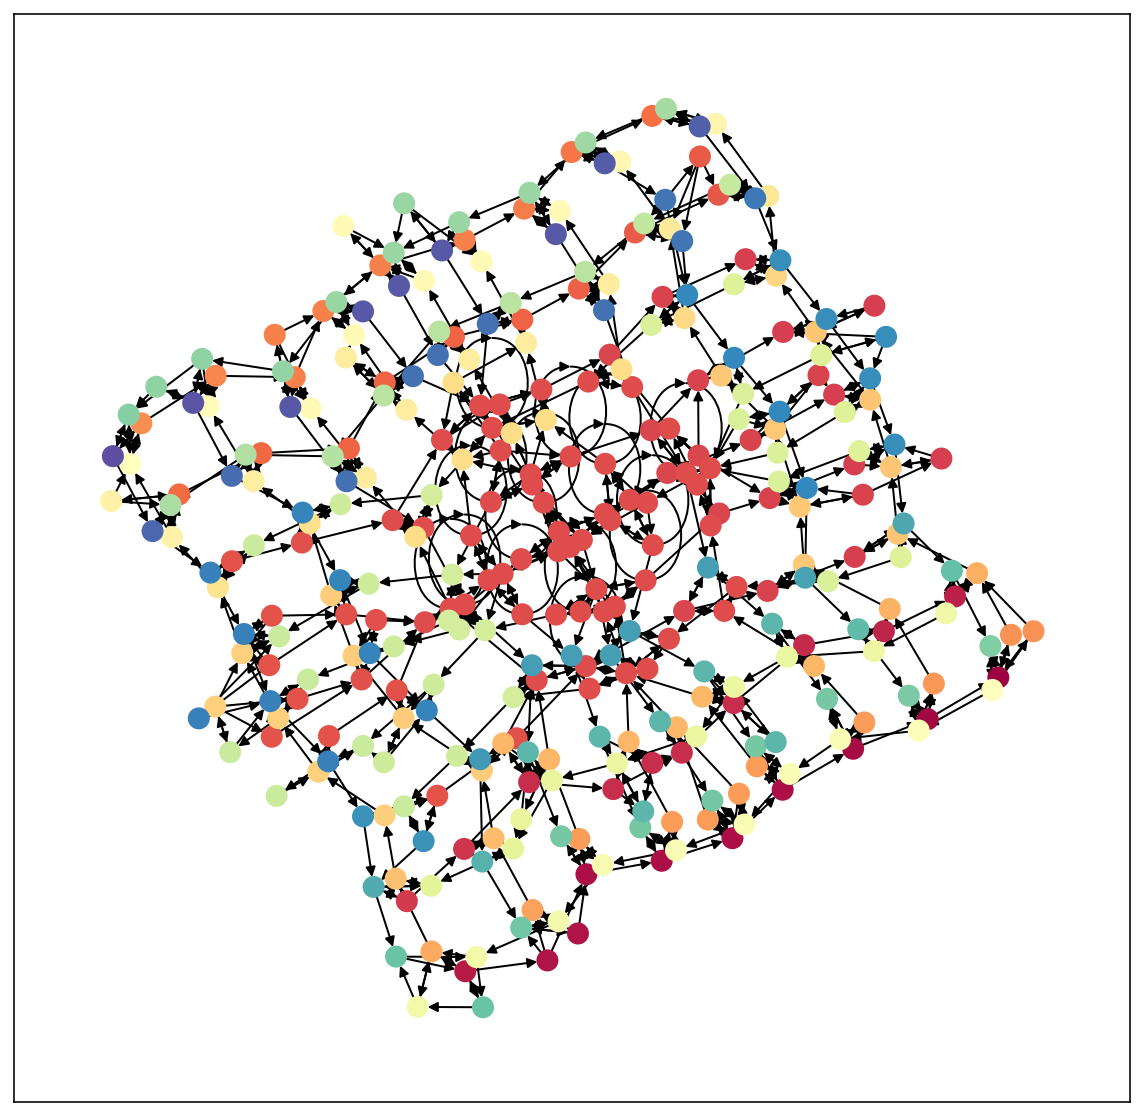

In [10]:
# @title Visualize graph
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.plot_graph(
    model.counts_matrix, states, n_clones, x.max(), ax=ax, node_size=100
)
plt.show()

In [11]:
# @title Create SE version of model
model_se = cscg_factory.build_cscg(implementation='se', seed=0, kwargs=kwargs)
model_se.set_pseudocount(0.0)
model_se.set_counts_matrix(model.counts_matrix)

In [12]:
# @title Map clones to positions in the layout
clones = np.unique(states)
node_pos_a = {}
for i, state in enumerate(np.array(states)):
  ri, ci = rc[i]
  ri -= PH
  ci -= PH
  hi = h[i]

  if (ri, ci, hi) not in node_pos_a:
    node_pos_a[(ri, ci, hi)] = {}

  if (ri, ci, hi) in node_pos_a:
    if state not in node_pos_a[(ri, ci, hi)]:
      node_pos_a[(ri, ci, hi)][state] = 0
    node_pos_a[(ri, ci, hi)][state] += 1

# now for each node position, find state with max values
node_pos = {}
for ri, ci, hi in node_pos_a:
  keys = list(node_pos_a[(ri, ci, hi)].keys())
  vals = list(node_pos_a[(ri, ci, hi)].values())
  clone = keys[np.argmax(vals)]
  clone_idx = np.where(clones == clone)[0][0]
  node_pos[(ri, ci, hi)] = (clone, clone_idx)

In [13]:
E_true = jnp.array(model_se.emission_matrix_default.copy())

# Compute Hamming distance between templates
templates = list(observation_dict.keys())
templates = np.array(templates)

# Hamming distance matrix
Nh = len(templates)
HMat = np.zeros(shape=(Nh, Nh))
for i in range(Nh):
  for j in range(i):
    HMat[i, j] = np.sum(templates[i] != templates[j])
    HMat[j, i] = HMat[i, j]

# Smoothed emission matrix
E_scaling = 1
E_smooth = np.zeros_like(E_true)

for i in range(E_true.shape[0]):
  idx = np.where(E_true[i] == 1)[0][0]
  E_smooth[i, :] = np.exp(-HMat[idx] ** 2 / (2 * E_scaling))

E_smooth += 1e-10

E_smooth /= E_smooth.sum(1, keepdims=True)

## Elongation of place fields in the HR layout

In [14]:
# @title Compute place fields in the SS layout
trial_len, num_trials = 2000, 250
gaussian_half_window_size = 1
gaussian_scaling = 0.1


RFs = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    seed=42,
)

100%|██████████| 250/250 [03:37<00:00,  1.15it/s]


In [15]:
# @title Compute place fields in the HR layout
RFs_HR = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map_HR.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    seed=42,
)

100%|██████████| 250/250 [03:37<00:00,  1.15it/s]


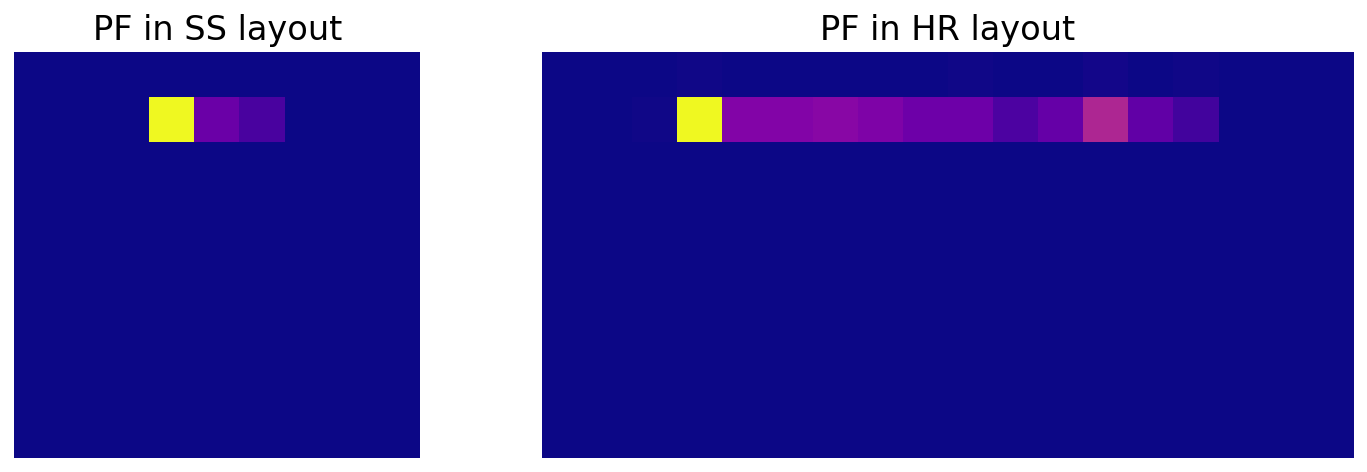

In [16]:
#@title Example place fields in SS and HR layouts
ri, ci, hi = 1, 3, 1
idx = node_pos[(ri, ci, hi)][1]
po = PH
cmap = 'plasma'
fig, axs = plt.subplots(
    1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]}
)
axs[0].imshow(RFs[idx, po:-po, po:-po], cmap=cmap)
axs[1].imshow(RFs_HR[idx, po:-po, po:-po], cmap=cmap)
axs[0].set_title('PF in SS layout')
axs[1].set_title('PF in HR layout')
for ax in axs.flat:
  ax.axis('off')

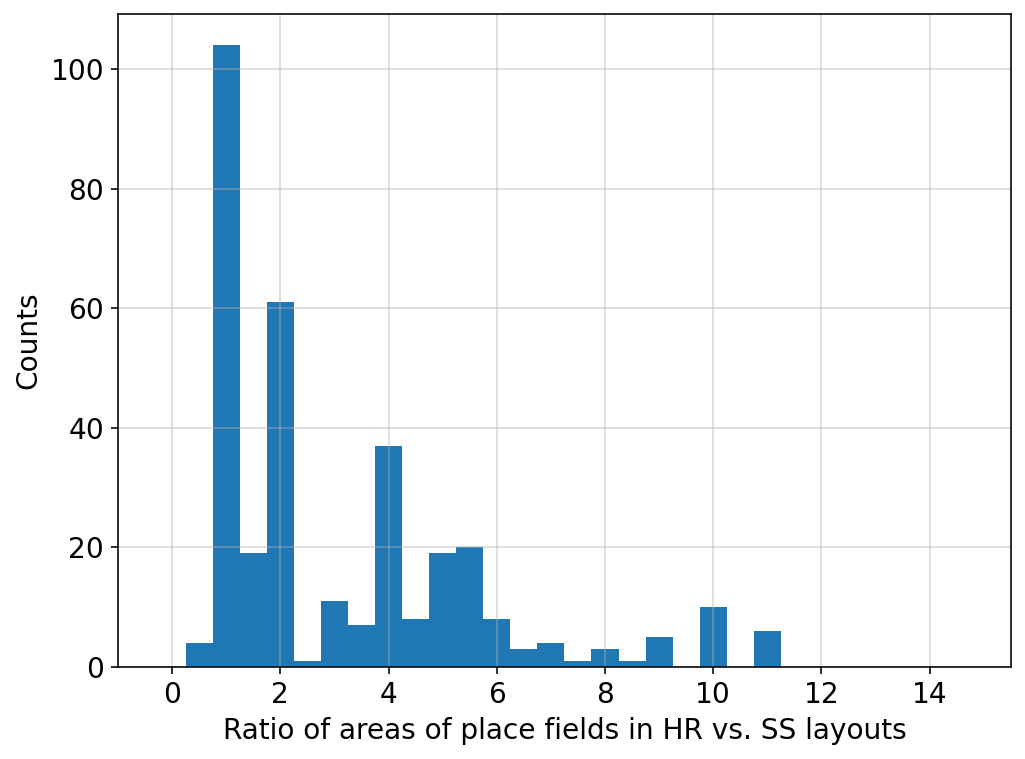

In [17]:
# @title Compute proportion of cells for which place fields expanded

# Normalize RFs
RFs_normalized = (
    RFs / np.nanmax(RFs.reshape(RFs.shape[0], -1), axis=1)[:, None, None]
)
RFs_HR_normalized = (
    RFs_HR
    / np.nanmax(RFs_HR.reshape(RFs_HR.shape[0], -1), axis=1)[:, None, None]
)

threshold = 0.1
coverage = (RFs_normalized[:, po:-po, po:-po] > threshold).sum(axis=(1, 2))
coverage_HR = (RFs_HR_normalized[:, po:-po, po:-po] > threshold).sum(
    axis=(1, 2)
)

expansion_ratio = coverage_HR / coverage

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(expansion_ratio, np.linspace(0, 15, 31) - 0.25)
ax.grid(True, alpha=0.5)
ax.set_xlabel('Ratio of areas of place fields in HR vs. SS layouts')
ax.set_ylabel('Counts')
plt.show()

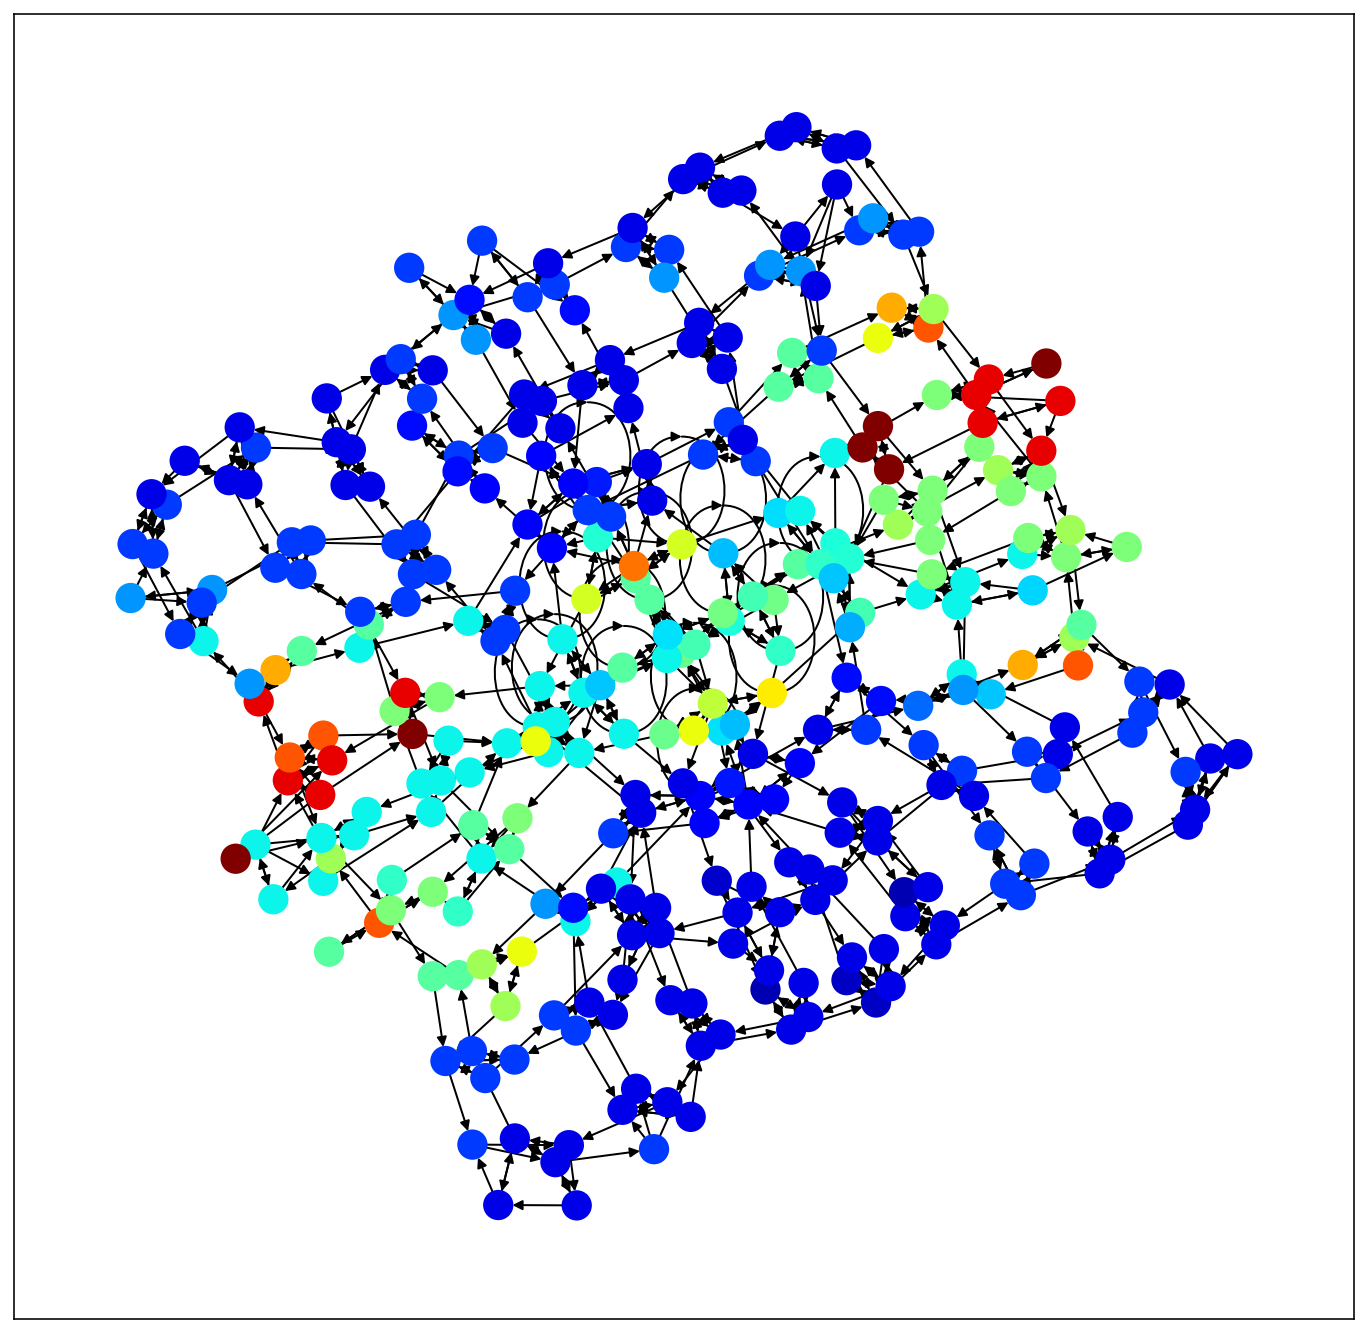

In [18]:
#@title Transition graph with nodes colored by expansion_ratio of place fields
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
utils.plot_graph(
    model.counts_matrix,
    clones,
    n_clones,
    x_max=x.max(),
    threshold=0,
    ax=ax,
    node_size=200,
    node_labels=expansion_ratio,
    cmap='jet'
)
plt.show()

## Directional place fields in the HR layout

In [19]:
# eastward walks

trial_len = 250
num_trials = 1000
possible_starting_positions = [
    (PH + i, PH) for i in range(rH)
]  # start from the left

RFs_eastward_walks = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map_HR.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    possible_starting_positions=possible_starting_positions,
    directionality='east',
    seed=42,
)

100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]


In [20]:
# westward walks

possible_starting_positions = [
    (PH + i, PH + 2 * rW - 1) for i in range(rH)
]  # start from the right

RFs_westward_walks = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map_HR.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    possible_starting_positions=possible_starting_positions,
    directionality='west',
    seed=42,
)

100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


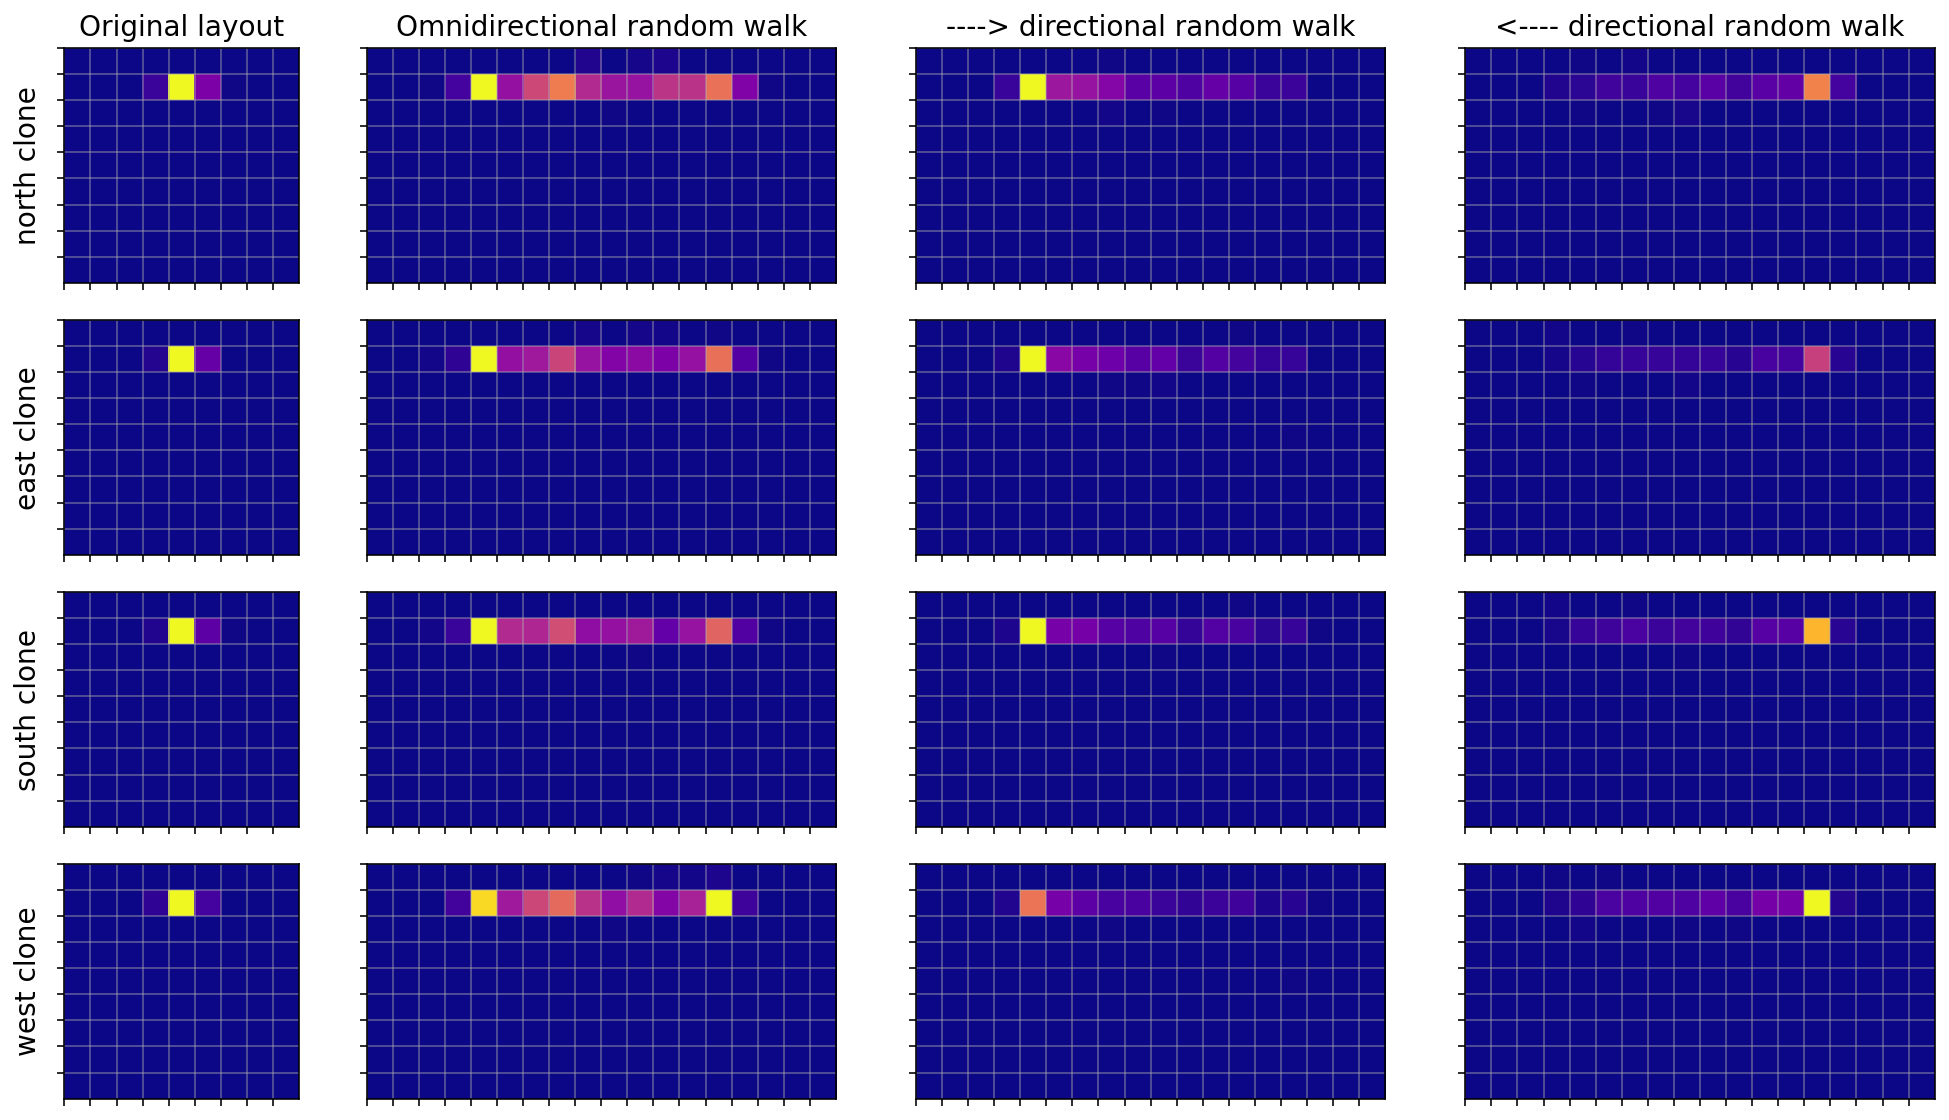

In [21]:
#@title Plot example place fields
ri, ci = 1, 4

titles = ['north', 'east', 'south', 'west']
cmap = 'plasma'

cell_ids = [node_pos[(ri, ci, hi)][1] for hi in range(4)]

fig, axs = plt.subplots(
    4,
    4,
    figsize=(14, 8),
    gridspec_kw={'width_ratios': [1, 2, 2, 2], 'height_ratios': [1, 1, 1, 1]},
)
for i in range(4):

  cell_idx = node_pos[(ri, ci, i)][1]
  rmax_e = np.nanmax(RFs_eastward_walks[cell_idx])
  rmax_w = np.nanmax(RFs_westward_walks[cell_idx])
  rmax = max(rmax_e, rmax_w)

  axs[i, 0].imshow(RFs[cell_idx, PH:-PH, PH:-PH], cmap=cmap)
  axs[i, 1].imshow(RFs_HR[cell_idx, PH:-PH, PH:-PH], cmap=cmap)

  axs[i, 2].imshow(
      RFs_eastward_walks[cell_idx, PH:-PH, PH:-PH], cmap=cmap, vmin=0, vmax=rmax
  )
  axs[i, 3].imshow(
      RFs_westward_walks[cell_idx, PH:-PH, PH:-PH], cmap=cmap, vmin=0, vmax=rmax
  )

  axs[i, 0].set_ylabel(titles[i] + ' clone', fontsize=14)

  for j in range(4):
    if j == 0:
      axs[i, j].set_xticks(np.arange(0, rW) - 0.5)
    else:
      axs[i, j].set_xticks(np.arange(0, 2 * rW) - 0.5)
    axs[i, j].set_yticks(np.arange(0, rH) - 0.5)
    axs[i, j].grid(True, alpha=0.5)
    axs[i, j].set_xticklabels([])
    axs[i, j].set_yticklabels([])

axs[0, 0].set_title('Original layout', fontsize=14)
axs[0, 1].set_title('Omnidirectional random walk', fontsize=14)
axs[0, 2].set_title('----> directional random walk', fontsize=14)
axs[0, 3].set_title('<---- directional random walk', fontsize=14)

plt.tight_layout()
plt.show()

## Compute place fields in VR and LS layouts

In [22]:
room_layout_LS = utils.generate_rectangular_layout(
    2 * rH, 2 * rW, padlen=PH, distinct_edges=True, distinct_corners=True
)
room_layout_VR = utils.generate_rectangular_layout(
    2 * rH, rW, padlen=PH, distinct_edges=True, distinct_corners=True
)

observation_map_LS, _ = utils.extract_egocentric_observations(
    room_layout_LS, PH, PW, observation_dict.copy()
)
observation_map_VR, _ = utils.extract_egocentric_observations(
    room_layout_VR, PH, PW, observation_dict.copy()
)

In [23]:
trial_len, num_trials = 2000, 250

RFs_VR = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map_VR.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    seed=42,
)

RFs_LS = utils.compute_receptive_fields(
    clones,
    model_se,
    E_smooth,
    observation_map_LS.copy(),
    trial_len=trial_len,
    num_trials=num_trials,
    gaussian_half_window_size=gaussian_half_window_size,
    gaussian_scaling=gaussian_scaling,
    seed=42,
)

100%|██████████| 250/250 [03:39<00:00,  1.14it/s]


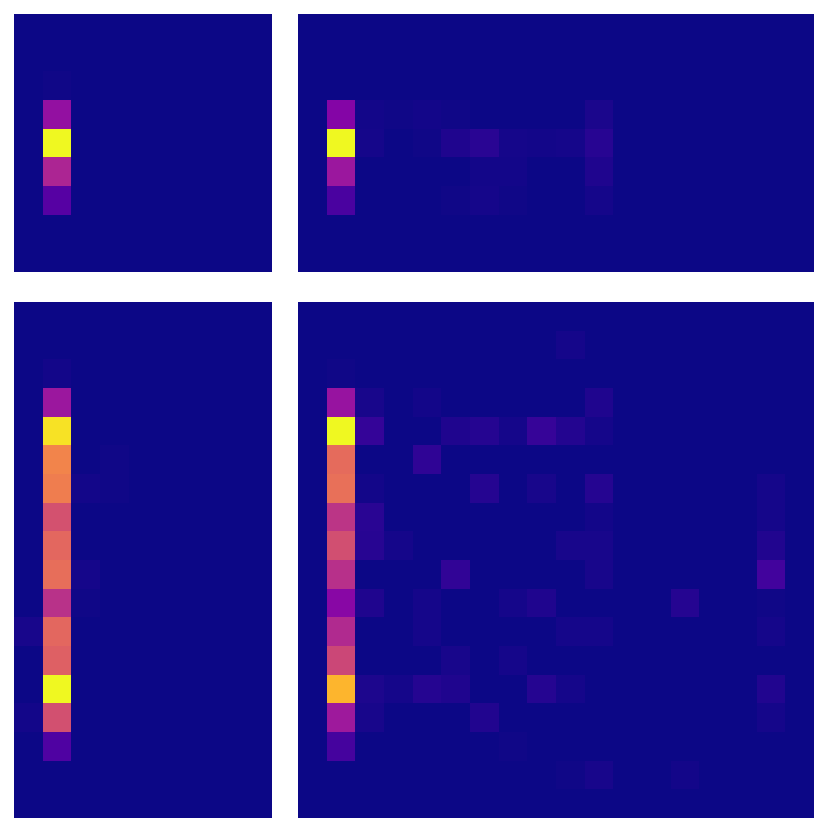

In [24]:
# @title Plot place fields for an example clone in all 4 rooms

RFs_SS = RFs

ri, ci, hi = 4, 1, 3
idx = node_pos[(ri, ci, hi)][1]

fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 6),
    gridspec_kw={'width_ratios': [1, 2], 'height_ratios': [1, 2]},
)

axs[0, 0].imshow(RFs_SS[idx][po:-po, po:-po], cmap=cmap)
axs[0, 0].axis('off')

axs[0, 1].imshow(RFs_HR[idx][po:-po, po:-po], cmap=cmap)
axs[0, 1].axis('off')

axs[1, 0].imshow(RFs_VR[idx][po:-po, po:-po], cmap=cmap)
axs[1, 0].axis('off')

axs[1, 1].imshow(RFs_LS[idx][po:-po, po:-po], cmap=cmap)
axs[1, 1].axis('off')


plt.tight_layout()
plt.show()